# 02 – Generate Positive Patch Samples
This notebook generates buffer-based training samples around each known porphyry copper deposit
Each center point (core positive sample) is expanded to multiple nearby points using random sampling

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from pathlib import Path
import matplotlib.pyplot as plt

# Step 1: Load core positive samples
input_file = Path("../../data/processed/positive_core_clean.csv")
df_core = pd.read_csv(input_file)

# Step 2: Convert to GeoDataFrame with WGS84 and reproject to metric CRS
gdf_core = gpd.GeoDataFrame(
    df_core,
    geometry=gpd.points_from_xy(df_core["LONGITUDE"], df_core["LATITUDE"]),
    crs="EPSG:4326"
)
gdf_core_proj = gdf_core.to_crs(epsg=3112)  # GDA94 / Australian Albers – good for distance in meters

# Step 3: Define buffer-based sampling function
def generate_points_within_buffer(center_point, radius_m, n_points):
    points = []
    for _ in range(n_points):
        angle = np.random.uniform(0, 2 * np.pi)
        distance = np.random.uniform(0, radius_m)
        dx = distance * np.cos(angle)
        dy = distance * np.sin(angle)
        points.append(Point(center_point.x + dx, center_point.y + dy))
    return points

Mean distance: 45378.23 m
Median distance: 16199.85 m
Max distance: 539164.26 m
Min distance: 164.65 m


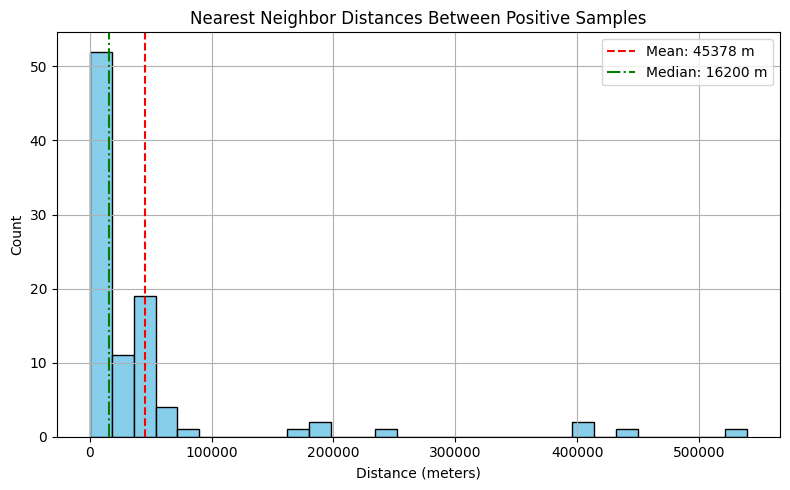

In [3]:
from sklearn.neighbors import NearestNeighbors

# Step 4: Extract coordinates and compute nearest neighbor distances
coords = np.array([(point.x, point.y) for point in gdf_core_proj.geometry])
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Note: distances[:, 0] is distance to itself (0), so we use distances[:, 1]
nearest_distances = distances[:, 1]

# Step 5: Summary statistics
mean_dist = nearest_distances.mean()
median_dist = np.median(nearest_distances)
max_dist = nearest_distances.max()
min_dist = nearest_distances.min()

print(f"Mean distance: {mean_dist:.2f} m")
print(f"Median distance: {median_dist:.2f} m")
print(f"Max distance: {max_dist:.2f} m")
print(f"Min distance: {min_dist:.2f} m")

# Step 6: Histogram visualization
plt.figure(figsize=(8, 5))
plt.hist(nearest_distances, bins=30, color='skyblue', edgecolor='black')
plt.axvline(mean_dist, color='red', linestyle='--', label=f"Mean: {mean_dist:.0f} m")
plt.axvline(median_dist, color='green', linestyle='-.', label=f"Median: {median_dist:.0f} m")
plt.title("Nearest Neighbor Distances Between Positive Samples")
plt.xlabel("Distance (meters)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Buffer Radius Selection Rationale

We initially set the buffer radius for positive sample augmentation to 5000 meters based on a combination of spatial analysis, data resolution, and geological relevance. According to our nearest neighbor distance analysis, the median distance between porphyry copper deposit points is approximately 19 km, while the minimum distance is around 460 meters. A 5 km radius strikes a balance between avoiding excessive overlap between sample patches and ensuring sufficient spatial coverage for geophysical feature extraction within each buffer zone.

This radius also aligns with the spatial resolution of our supporting datasets (e.g., GeoTIFF layers), allowing the model to capture meaningful geophysical patterns within a manageable spatial extent.

In future iterations, we plan to experiment with different buffer sizes, such as 3000 m and 7000 m, to assess their impact on sample diversity, spatial representativeness, and model performance. We also intend to implement buffer overlap checking to prevent sample redundancy and test the sensitivity of the model to varying spatial contexts.

In [4]:
# Step 4: Sampling configuration
buffer_radius_m = 5000  # 5km
samples_per_site = 10   # Number of points per deposit

# Step 5: Generate patch samples
generated = []
for _, row in gdf_core_proj.iterrows():
    buffer_points = generate_points_within_buffer(row.geometry, buffer_radius_m, samples_per_site)
    for pt in buffer_points:
        generated.append({
            "source_deposit": row.get("DEPOSIT", "unknown"),
            "LABEL": 1,
            "geometry": pt
        })

# Step 6: Convert to GeoDataFrame and reproject back to WGS84
gdf_patches = gpd.GeoDataFrame(generated, crs=gdf_core_proj.crs)
gdf_patches = gdf_patches.to_crs(epsg=4326)
gdf_patches["LONGITUDE"] = gdf_patches.geometry.x
gdf_patches["LATITUDE"] = gdf_patches.geometry.y

# Step 7: Save to CSV
output_path = Path("../../data/processed/positive_augmented_patch.csv")
output_path.parent.mkdir(parents=True, exist_ok=True)
gdf_patches.drop(columns="geometry").to_csv(output_path, index=False)

# Optional preview
gdf_patches.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   source_deposit  950 non-null    object  
 1   LABEL           950 non-null    int64   
 2   geometry        950 non-null    geometry
 3   LONGITUDE       950 non-null    float64 
 4   LATITUDE        950 non-null    float64 
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 37.2+ KB


## Buffer Expansion Visualisation

This map shows the spatial distribution of original porphyry copper deposit locations (red dots) and their corresponding buffer expansion zones (blue circles), which are used to generate additional positive training samples for machine learning-based mineral prospectivity modelling.

How It Was Generated:

- Each red dot represents a known porphyry copper deposit point from the positive_core_clean.csv dataset.

- A 5 km buffer was created around each deposit point to define a spatial window (gdf_patches) for feature extraction.

- All points and patches were projected to Web Mercator (EPSG:3857) and overlaid on a base map using contextily.

Well-distributed buffer coverage: The 5 km buffer radius provides localized spatial context around each deposit without excessive overlap, suitable for training localized geophysical pattern detection.

## Next Steps
- Filter out overlapping patches (if concern exists).
- Visualise the distribution of planned negative sample zones in future work to ensure spatial balance.

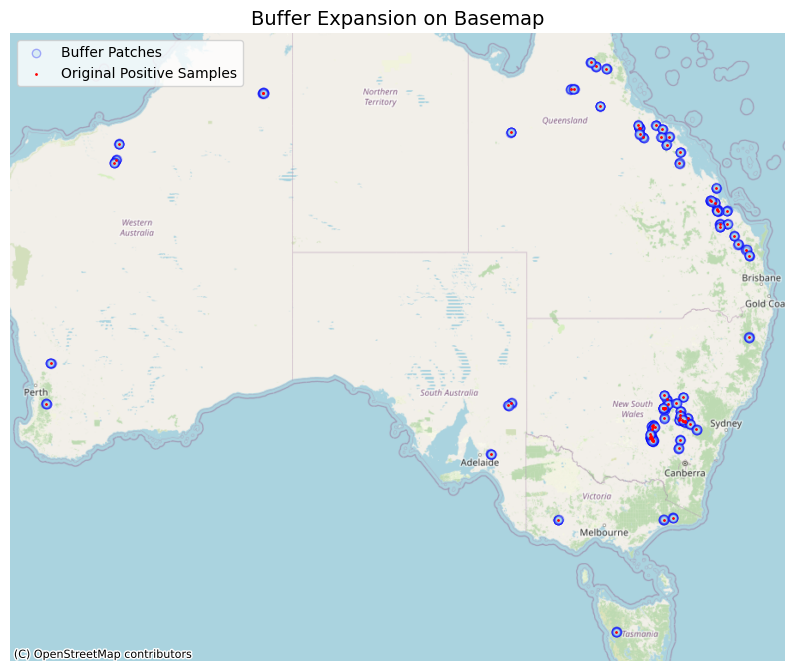

In [5]:
import contextily as ctx

gdf_patches_web = gdf_patches.to_crs(epsg=3857)
gdf_web = gdf_core.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_patches_web.plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.3, label='Buffer Patches')
gdf_web.plot(ax=ax, color='red', markersize=1, label='Original Positive Samples')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Buffer Expansion on Basemap", fontsize=14)
plt.legend()
plt.axis('off')
plt.show()
